# Place Recognition Failure Case Analysis

This notebook analyzes failure patterns in place recognition models by examining retrieval results and visualizing query-database correspondences through recall matrices.

## Workflow
1. Configure analysis parameters (dataset, model, directories)
2. Load evaluation results with automated file discovery
3. Generate recall matrices and identify failure patterns
4. Perform detailed analysis of worst-performing query-database pairs

In [1]:
"""Import required libraries for place recognition failure analysis."""

import re
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchshow as ts

from opr.testers.place_recognition.model import RetrievalResultsCollection
from mssplace.datasets import NCLTDatasetWithText, OxfordDatasetWithText

print("Libraries imported successfully")

INFO:faiss.loader:Loading faiss with AVX2 support.
INFO:faiss.loader:Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
INFO:faiss.loader:Loading faiss.
INFO:faiss.loader:Successfully loaded faiss.
/home/docker_mssplace/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [2]:
"""Verify evaluation results directory exists."""

RESULTS_DIR = Path().cwd() / "evaluation_results"
if not RESULTS_DIR.exists():
    print(f"ERROR: Results directory not found: {RESULTS_DIR}")
    print("Please ensure evaluation results exist before running analysis.")
else:
    print(f"Results directory found: {RESULTS_DIR}")

Results directory found: /home/docker_mssplace/MSSPlace/scripts/evaluation/evaluation_results


In [3]:
"""Configure visualization settings for consistent plot appearance."""

plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.size': 12
})
sns.set_style("whitegrid")
print("Visualization settings configured")

Visualization settings configured


In [4]:
# =============================================================================
# ANALYSIS CONFIGURATION
# =============================================================================

"""Configuration parameters for failure analysis."""

# Dataset and model selection
DATASET = 'nclt'  # Options: 'oxford', 'nclt'
MODEL_NAME = 'mssplace-lis'  # Options: 'mssplace-li', 'mssplace-lis', 'mssplace-lit', 'mssplace-list'

# Data directory configuration
DATA_DIR = Path("/home/docker_mssplace/Datasets/OpenPlaceRecognition")
DATA_DIR = DATA_DIR / "NCLT_preprocessed" if DATASET == 'nclt' else DATA_DIR / "pnvlad_oxford_robotcar"

# Sensor configurations for different model variants
# li: LiDAR + Images, lis: + Semantic masks, lit: + Text descriptions, list: all modalities
SENSOR_CONFIGS = {
    "oxford": {
        "mssplace-li": ["pointcloud_lidar", "image_stereo_centre", "image_mono_left", "image_mono_rear", "image_mono_right"],
        "mssplace-lis": ["pointcloud_lidar", "image_stereo_centre", "image_mono_left", "image_mono_rear", "image_mono_right",
                        "mask_stereo_centre", "mask_mono_left", "mask_mono_rear", "mask_mono_right"],
        "mssplace-lit": ["pointcloud_lidar", "image_stereo_centre", "image_mono_left", "image_mono_rear", "image_mono_right",
                        "text_stereo_centre", "text_mono_left", "text_mono_rear", "text_mono_right"],
        "mssplace-list": ["pointcloud_lidar", "image_stereo_centre", "image_mono_left", "image_mono_rear", "image_mono_right",
                         "mask_stereo_centre", "mask_mono_left", "mask_mono_rear", "mask_mono_right",
                         "text_stereo_centre", "text_mono_left", "text_mono_rear", "text_mono_right"],
    },
    "nclt": {
        "mssplace-li": ["pointcloud_lidar", "image_Cam1", "image_Cam2", "image_Cam3", "image_Cam4", "image_Cam5"],
        "mssplace-lis": ["pointcloud_lidar", "image_Cam1", "image_Cam2", "image_Cam3", "image_Cam4", "image_Cam5",
                        "mask_Cam1", "mask_Cam2", "mask_Cam3", "mask_Cam4", "mask_Cam5"],
        "mssplace-lit": ["pointcloud_lidar", "image_Cam1", "image_Cam2", "image_Cam3", "image_Cam4", "image_Cam5",
                        "text_Cam1", "text_Cam2", "text_Cam3", "text_Cam4", "text_Cam5"],
        "mssplace-list": ["pointcloud_lidar", "image_Cam1", "image_Cam2", "image_Cam3", "image_Cam4", "image_Cam5",
                         "mask_Cam1", "mask_Cam2", "mask_Cam3", "mask_Cam4", "mask_Cam5",
                         "text_Cam1", "text_Cam2", "text_Cam3", "text_Cam4", "text_Cam5"],
    }
}

# Validate configuration
assert DATASET in ['oxford', 'nclt'], f"Invalid dataset: {DATASET}"
assert MODEL_NAME in SENSOR_CONFIGS[DATASET], f"Invalid model for {DATASET}: {MODEL_NAME}"

print(f"Configuration set: {DATASET.upper()} dataset with {MODEL_NAME} model")
print(f"Data directory: {DATA_DIR}")
print(f"Sensors: {len(SENSOR_CONFIGS[DATASET][MODEL_NAME])} modalities")

Configuration set: NCLT dataset with mssplace-lis model
Data directory: /home/docker_mssplace/Datasets/OpenPlaceRecognition/NCLT_preprocessed
Sensors: 11 modalities


In [5]:
"""Utility functions for file discovery and dataset creation."""


def find_most_recent_results(results_dir: Path, dataset: str, model: str) -> Path | None:
    """Find the most recent results file for a given dataset and model.

    Searches for files matching pattern: {dataset}_{model}_results_{timestamp}.json
    where timestamp format is YYYYMMDD_HHMMSS.

    Args:
        results_dir: Directory containing results files
        dataset: Dataset name (e.g., 'nclt', 'oxford')
        model: Model name (e.g., 'mssplace-lis')

    Returns:
        Path to most recent results file, or None if no matching files found
    """
    if not results_dir.exists():
        print(f"WARNING: Results directory does not exist: {results_dir}")
        return None

    pattern = f"{dataset}_{model}_results_*.json"
    matching_files = list(results_dir.glob(pattern))

    if not matching_files:
        print(f"ERROR: No results files found matching pattern: {pattern}")
        print(f"Search directory: {results_dir}")
        return None

    print(f"Found {len(matching_files)} matching files")

    # Parse timestamps and sort by most recent
    files_with_timestamps = []
    for file_path in matching_files:
        match = re.search(r'_(\d{8}_\d{6})\.json$', file_path.name)
        if match:
            timestamp_str = match.group(1)
            try:
                timestamp = datetime.strptime(timestamp_str, '%Y%m%d_%H%M%S')
                files_with_timestamps.append((file_path, timestamp))
                print(f"  {file_path.name} -> {timestamp.strftime('%Y-%m-%d %H:%M:%S')}")
            except ValueError as e:
                print(f"WARNING: Could not parse timestamp from {file_path.name}: {e}")
        else:
            print(f"WARNING: No timestamp found in filename: {file_path.name}")

    if not files_with_timestamps:
        print("ERROR: No files with valid timestamps found")
        return None

    # Sort by timestamp (most recent first)
    files_with_timestamps.sort(key=lambda x: x[1], reverse=True)
    most_recent_file, most_recent_timestamp = files_with_timestamps[0]

    print("\nMost recent file:")
    print(f"  File: {most_recent_file.name}")
    print(f"  Timestamp: {most_recent_timestamp.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"  Size: {most_recent_file.stat().st_size / 1024:.1f} KB")

    return most_recent_file


def create_dataset(dataset_name: str, data_dir: Path, sensor_setup: list[str]) -> torch.utils.data.Dataset:
    """Create dataset instance with specified sensor configuration.

    Uses text-enabled dataset classes for compatibility with all model variants.

    Args:
        dataset_name: Dataset name ('oxford' or 'nclt')
        data_dir: Path to dataset directory
        sensor_setup: List of sensors/modalities to load

    Returns:
        Dataset instance ready for testing
    """
    print(f"Creating {dataset_name} dataset from: {data_dir}")
    print(f"Sensor setup: {sensor_setup}")

    if dataset_name == "oxford":
        dataset = OxfordDatasetWithText(
            dataset_root=data_dir,
            subset="test",
            data_to_load=sensor_setup,
            pointcloud_quantization_size=0.01,
        )
    elif dataset_name == "nclt":
        dataset = NCLTDatasetWithText(
            dataset_root=data_dir,
            subset="test",
            data_to_load=sensor_setup,
        )
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    print(f"Dataset created with {len(dataset)} samples")
    return dataset


def format_percentage(value: float) -> str:
    """Format decimal value as percentage with 2 decimal places (truncated)."""
    integer_part = int(value * 100)
    decimal_part = int((value * 100) % 1 * 100)
    return f"{integer_part}.{decimal_part:02d}%"


print("Utility functions defined")


Utility functions defined


## Data Loading and Results Discovery

Automatically discover the most recent evaluation results and load the corresponding dataset for analysis.

In [6]:
"""Find and load the most recent evaluation results."""

print(f"Searching for: {DATASET}_{MODEL_NAME}_results_*.json")

results_file = find_most_recent_results(RESULTS_DIR, DATASET, MODEL_NAME)
if not results_file:
    print(f"\nAvailable files in {RESULTS_DIR}:")
    for file in sorted(RESULTS_DIR.glob("*.json")):
        print(f"  {file.name}")
    raise FileNotFoundError(f"No results file found for {DATASET} + {MODEL_NAME}")

# Load the results collection
results = RetrievalResultsCollection.load(results_file)
print(f"Loaded {len(results)} result pairs from: {results_file.name}")

Searching for: nclt_mssplace-lis_results_*.json
Found 1 matching files
  nclt_mssplace-lis_results_20250525_165818.json -> 2025-05-25 16:58:18

Most recent file:
  File: nclt_mssplace-lis_results_20250525_165818.json
  Timestamp: 2025-05-25 16:58:18
  Size: 29811.7 KB
Loaded 90 result pairs from: nclt_mssplace-lis_results_20250525_165818.json


In [7]:
"""Load dataset corresponding to the evaluation results."""

dataset = create_dataset(
    dataset_name=DATASET,
    data_dir=DATA_DIR,
    sensor_setup=SENSOR_CONFIGS[DATASET][MODEL_NAME]
)

# Extract unique track identifiers for visualization labels
track_list = list(dataset.dataset_df["track"].unique())
print(f"Found {len(track_list)} unique tracks: {track_list}")

Creating nclt dataset from: /home/docker_mssplace/Datasets/OpenPlaceRecognition/NCLT_preprocessed
Sensor setup: ['pointcloud_lidar', 'image_Cam1', 'image_Cam2', 'image_Cam3', 'image_Cam4', 'image_Cam5', 'mask_Cam1', 'mask_Cam2', 'mask_Cam3', 'mask_Cam4', 'mask_Cam5']
Dataset created with 2745 samples
Found 10 unique tracks: ['2012-01-08', '2012-01-22', '2012-02-12', '2012-02-18', '2012-03-31', '2012-05-26', '2012-08-04', '2012-10-28', '2012-11-04', '2012-12-01']


## Recall Matrix Analysis

Generate recall matrix where element (i,j) represents Recall@1 when track i queries track j. Diagonal elements (self-matches) are excluded from evaluation. Perfect matches appear in green (1.0), failures in red (0.0).

In [ ]:
"""Generate and analyze recall matrix from retrieval results."""

def create_recall_matrix(results: RetrievalResultsCollection) -> np.ndarray:
    """Create matrix where entry (i,j) = Recall@1 for query track i vs database track j."""
    query_tracks, db_tracks = results.num_tracks
    n_tracks = max(query_tracks, db_tracks)

    matrix = np.ones((n_tracks, n_tracks), dtype=np.float32)

    for res in results.results:
        i, j = res.query_track_id, res.database_track_id
        if i is not None and j is not None:
            matrix[i, j] = res.recall_at_n[0]  # Recall@1 is first element

    return matrix


# Generate the recall matrix
recall_matrix = create_recall_matrix(results)

# Compute summary statistics (excluding diagonal)
mask = ~np.eye(recall_matrix.shape[0], dtype=bool)
off_diagonal = recall_matrix[mask]

print("Recall@1 Matrix Summary:")
print(f"  Shape: {recall_matrix.shape}")
print(f"  Off-diagonal mean: {off_diagonal.mean():.3f}")
print(f"  Min/Max: {off_diagonal.min():.3f} / {off_diagonal.max():.3f}")

Recall@1 Matrix Summary:
  Shape: (10, 10)
  Off-diagonal mean: 0.954
  Success rate: 1.000
  Min/Max: 0.892 / 1.000


## Matrix Visualization and Pattern Analysis

Create heatmap visualization and analyze failure patterns to identify problematic tracks and systematic issues.

CREATING RECALL@1 HEATMAP VISUALIZATION
Colormap range: 0.892 to 1.000


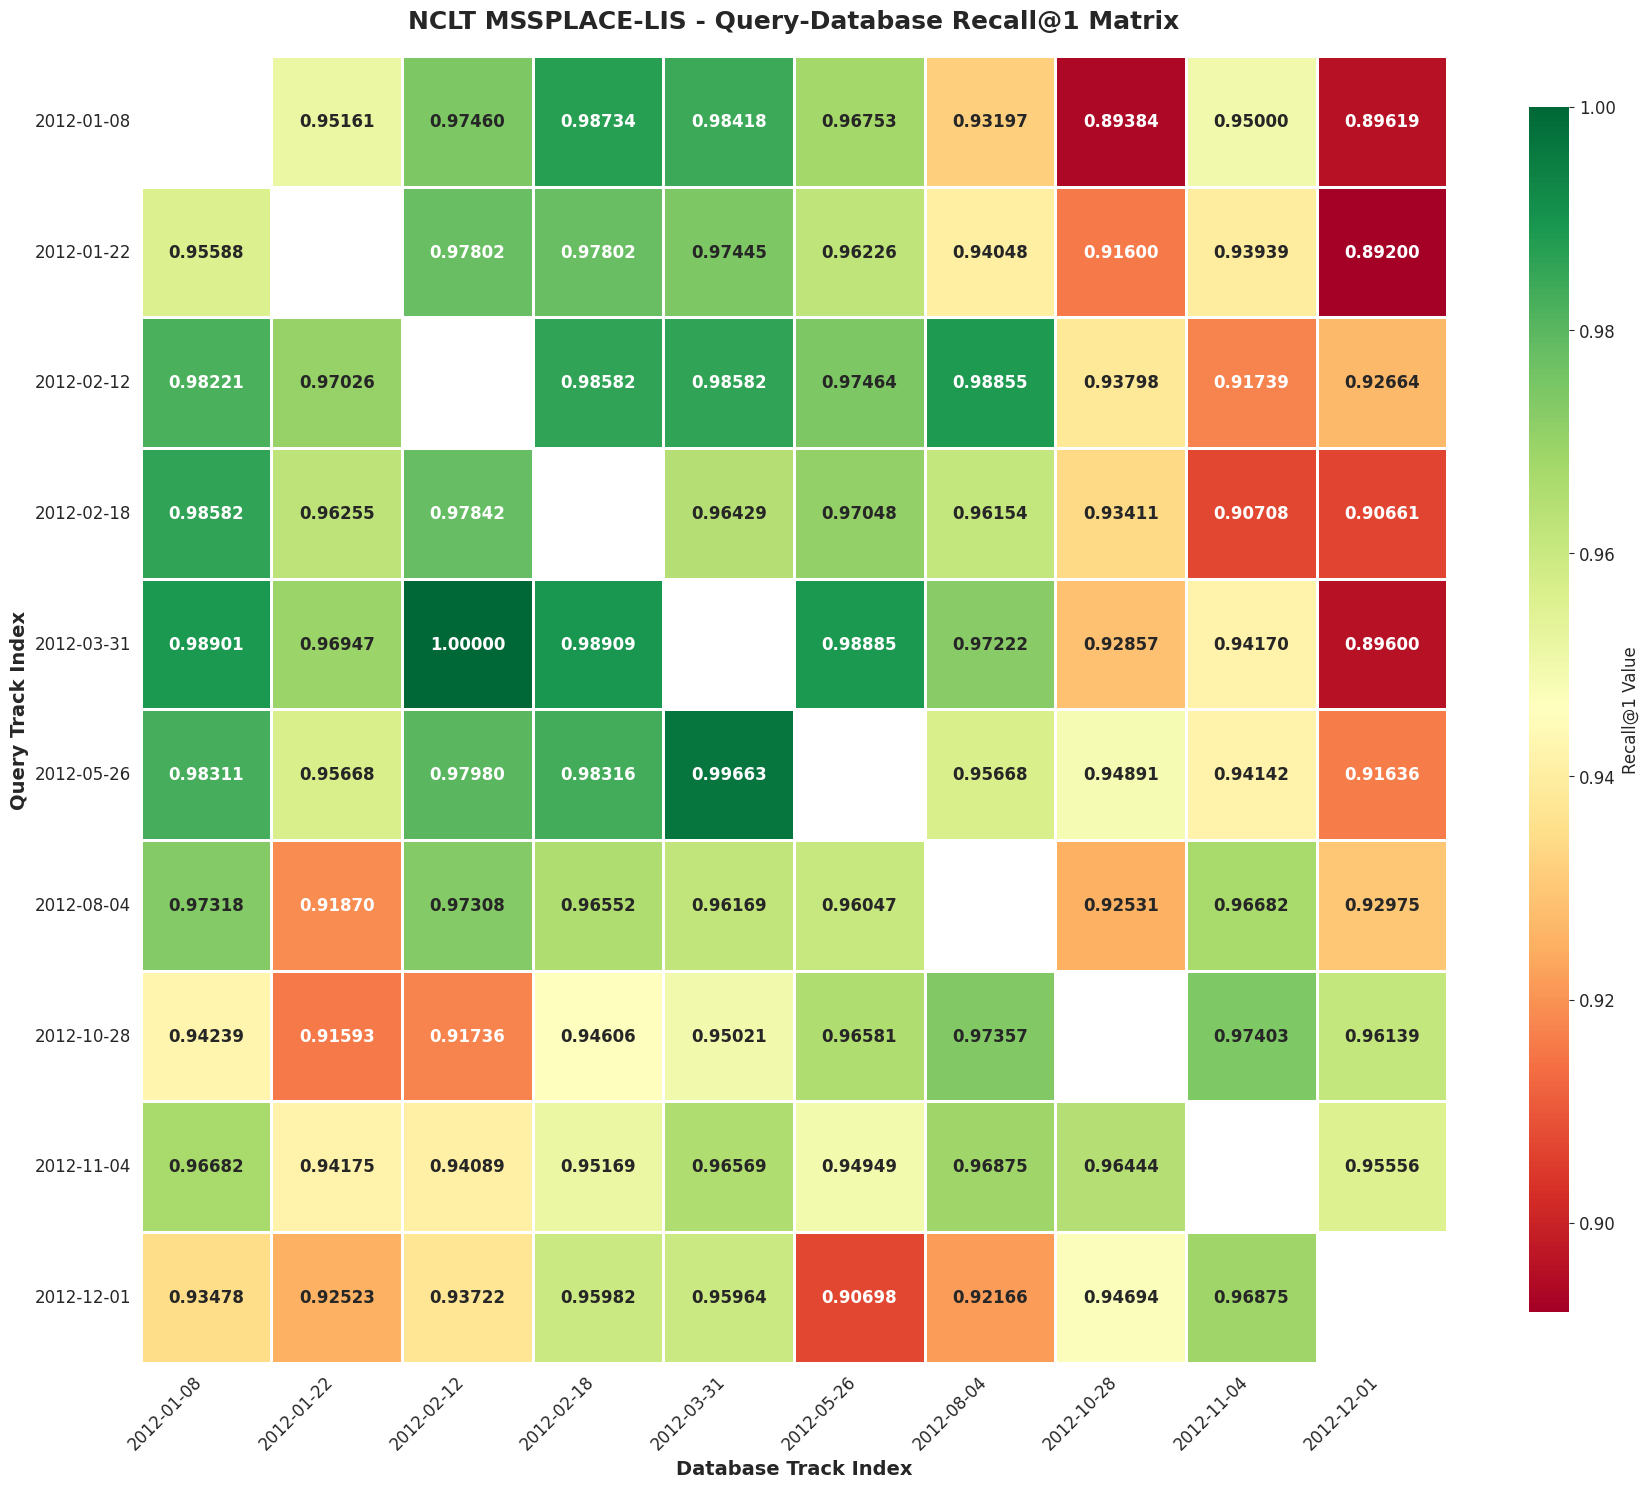


MATRIX PATTERN ANALYSIS

OVERALL SUCCESS RATE:
  0.9537666440010071

WORST QUERY TRACK:
  9

BEST QUERY TRACK:
  4

WORST DB TRACK:
  9

BEST DB TRACK:
  3

QUERY PERFORMANCE RANGE:
  (0.9401137, 0.96387917)

DB PERFORMANCE RANGE:
  (0.92005676, 0.97183585)


In [9]:
"""Create heatmap visualization and analyze matrix patterns."""

def create_recall_heatmap(
    recall_matrix: np.ndarray,
    track_labels: list[str] | None = None,
    figsize: tuple[int, int] = (16, 14),
    annotate_values: bool = True,
    value_format: str = ".2f",
    title: str = "Query-Database Recall@1 Correspondence Matrix"
) -> tuple[plt.Figure, plt.Axes]:
    """Create annotated heatmap of recall@1 matrix with white diagonal overlay."""
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate colormap range excluding diagonal for better contrast
    mask = ~np.eye(recall_matrix.shape[0], dtype=bool)
    off_diagonal_values = recall_matrix[mask]
    vmin = off_diagonal_values.min() if off_diagonal_values.size > 0 else 0.0
    vmax_val = 1.0

    print(f"Colormap range: {vmin:.3f} to {vmax_val:.3f}")

    # Create heatmap
    sns.heatmap(
        recall_matrix,
        annot=annotate_values,
        fmt=value_format,
        cmap='RdYlGn',
        vmin=vmin,
        vmax=vmax_val,
        square=True,
        linewidths=2,
        annot_kws={"weight": "bold"},
        cbar_kws={
            'label': 'Recall@1 Value',
            'shrink': 0.8,
            'aspect': 30
        },
        xticklabels=track_labels,
        yticklabels=track_labels,
        ax=ax
    )

    # White diagonal overlay (self-matches excluded from evaluation)
    for i in range(min(recall_matrix.shape)):
        ax.add_patch(plt.Rectangle((i, i), 1, 1, facecolor='white', edgecolor='gray', alpha=1.0, lw=0))

    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Database Track Index', fontsize=14, fontweight='bold')
    ax.set_ylabel('Query Track Index', fontsize=14, fontweight='bold')

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    ax.grid(True, which='major', color='white', linewidth=4, alpha=0.3)
    plt.tight_layout()

    return fig, ax


def analyze_matrix_patterns(recall_matrix: np.ndarray) -> dict[str, any]:
    """Analyze patterns to identify problematic tracks and systematic issues."""
    mask = ~np.eye(recall_matrix.shape[0], dtype=bool)
    off_diagonal = recall_matrix[mask]

    # Query performance (row-wise analysis)
    query_performance = np.array([recall_matrix[i, mask[i]].mean() for i in range(recall_matrix.shape[0])])

    # Database performance (column-wise analysis)
    db_performance = np.array([recall_matrix[mask[:, j], j].mean() for j in range(recall_matrix.shape[1])])

    return {
        'overall_success_rate': off_diagonal.mean(),
        'worst_query_track': int(np.argmin(query_performance)),
        'best_query_track': int(np.argmax(query_performance)),
        'worst_db_track': int(np.argmin(db_performance)),
        'best_db_track': int(np.argmax(db_performance)),
        'query_performance_range': (query_performance.min(), query_performance.max()),
        'db_performance_range': (db_performance.min(), db_performance.max())
    }


# Create heatmap visualization
print("=" * 60)
print("CREATING RECALL@1 HEATMAP VISUALIZATION")
print("=" * 60)

fig, ax = create_recall_heatmap(
    recall_matrix=recall_matrix,
    track_labels=track_list,
    figsize=(18, 16),
    annotate_values=True,
    value_format=".5f",
    title=f"{DATASET.upper()} {MODEL_NAME.upper()} - Query-Database Recall@1 Matrix"
)

plt.show()

# Perform pattern analysis
pattern_analysis = analyze_matrix_patterns(recall_matrix)

print("\n" + "=" * 60)
print("MATRIX PATTERN ANALYSIS")
print("=" * 60)
for category, data in pattern_analysis.items():
    print(f"\n{category.upper().replace('_', ' ')}:")
    if isinstance(data, dict):
        for key, value in data.items():
            print(f"  {key.replace('_', ' ').title()}: {value}")
    else:
        print(f"  {data}")

## Worst Query-Database Pair Analysis

Identify and analyze the worst-performing query-database pairs based on lowest recall values. This helps pinpoint specific track combinations that consistently fail to retrieve relevant matches.


In [10]:
"""Identify and analyze the worst-performing query-database pair."""

# Find the worst-performing pair from the recall matrix
# mask = ~np.eye(recall_matrix.shape[0], dtype=bool)
worst_idx = np.unravel_index(np.argmin(recall_matrix), recall_matrix.shape)
worst_pair = {"query_id": worst_idx[0], "db_id": worst_idx[1]}

print(f"Worst performing pair: Query Track {worst_pair['query_id']} -> Database Track {worst_pair['db_id']}")
print(f"Recall@1: {recall_matrix[worst_pair['query_id'], worst_pair['db_id']]:.5f}")

# Find the corresponding RetrievalResults object
worst_results = None
for result in results.results:
    if result.query_track_id == worst_pair["query_id"] and result.database_track_id == worst_pair["db_id"]:
        worst_results = result
        break

if worst_results is not None:
    print("\nFound RetrievalResults for worst pair:")
    print(f"  Query Track: {worst_results.query_track_id} -> Database Track: {worst_results.database_track_id}")
    print(f"  Recall@1: {worst_results.recall_at_n[0]:.5f}")
    print(f"  Recall@1%: {worst_results.recall_at_one_percent:.5f}")
    print(f"  Queries with matches: {worst_results.queries_with_matches}/{worst_results.num_queries}")
    print(f"  Distance threshold: {worst_results.distance_threshold}m")
    if worst_results.top1_distance is not None:
        print(f"  Mean top-1 distance: {worst_results.top1_distance:.3f}m")
else:
    print(f"ERROR: No RetrievalResults found for pair: query={worst_pair['query_id']}, db={worst_pair['db_id']}")
    print("Available query-database pairs:")
    for result in results.results[:5]:
        print(f"  Query {result.query_track_id} -> Database {result.database_track_id}")
    print("  ...")

Worst performing pair: Query Track 1 -> Database Track 9
Recall@1: 0.89200

Found RetrievalResults for worst pair:
  Query Track: 1 -> Database Track: 9
  Recall@1: 0.89200
  Recall@1%: 0.94400
  Queries with matches: 250/275
  Distance threshold: 25.0m
  Mean top-1 distance: 4.415m


In [11]:
"""Detailed analysis of the worst-performing pair."""

if worst_results is not None:
    print("=" * 60)
    print("DETAILED FAILURE ANALYSIS")
    print("=" * 60)

    # Per-query performance analysis within this pair
    num_successful_queries = np.sum(worst_results.is_match[:, 0])  # Top-1 matches
    success_rate = num_successful_queries / worst_results.num_queries

    print("\nPer-Query Analysis:")
    print(f"  Total queries: {worst_results.num_queries}")
    print(f"  Successful top-1 matches: {num_successful_queries}")
    print(f"  Success rate: {success_rate:.3f} ({success_rate*100:.1f}%)")

    # Distance statistics
    top1_distances = worst_results.embedding_distances[:, 0]
    geo_distances = worst_results.geographic_distances[:, 0]

    print("\nDistance Statistics:")
    print("  Embedding distances (top-1):")
    print(f"    Mean: {top1_distances.mean():.4f}")
    print(f"    Std:  {top1_distances.std():.4f}")
    print(f"    Min:  {top1_distances.min():.4f}")
    print(f"    Max:  {top1_distances.max():.4f}")

    print("  Geographic distances (top-1):")
    print(f"    Mean: {geo_distances.mean():.2f}m")
    print(f"    Std:  {geo_distances.std():.2f}m")
    print(f"    Min:  {geo_distances.min():.2f}m")
    print(f"    Max:  {geo_distances.max():.2f}m")

    # Identify most problematic individual queries
    failed_queries = np.where(~worst_results.is_match[:, 0])[0]

    if len(failed_queries) > 0:
        print("\nMost Problematic Queries:")
        print(f"  Total failed queries: {len(failed_queries)}")

        # Show worst 10 by embedding distance
        worst_indices = failed_queries[np.argsort(top1_distances[failed_queries])[-10:]]
        worst_indices_global = worst_results.query_indices[worst_indices]
        worst_db_matches_global = worst_results.database_indices[worst_indices]

        print("  Worst 10 by embedding distance:")
        for idx in worst_indices:
            print(f"    Query {idx}: emb_dist={top1_distances[idx]:.4f}, geo_dist={geo_distances[idx]:.1f}m")

    print("\nTrack Information:")
    query_track_name = track_list[worst_results.query_track_id] if worst_results.query_track_id < len(track_list) else "Unknown"
    db_track_name = track_list[worst_results.database_track_id] if worst_results.database_track_id < len(track_list) else "Unknown"
    print(f"  Query Track {worst_results.query_track_id}: {query_track_name}")
    print(f"  Database Track {worst_results.database_track_id}: {db_track_name}")
else:
    print("Cannot perform detailed analysis - worst_results not found.")

DETAILED FAILURE ANALYSIS

Per-Query Analysis:
  Total queries: 275
  Successful top-1 matches: 223
  Success rate: 0.811 (81.1%)

Distance Statistics:
  Embedding distances (top-1):
    Mean: 4.9259
    Std:  1.5972
    Min:  2.2866
    Max:  10.1874
  Geographic distances (top-1):
    Mean: 30.72m
    Std:  69.66m
    Min:  0.21m
    Max:  409.09m

Most Problematic Queries:
  Total failed queries: 52
  Worst 10 by embedding distance:
    Query 234: emb_dist=8.6590, geo_dist=207.8m
    Query 230: emb_dist=8.7711, geo_dist=214.2m
    Query 8: emb_dist=8.9480, geo_dist=26.7m
    Query 11: emb_dist=8.9951, geo_dist=26.7m
    Query 9: emb_dist=9.1797, geo_dist=322.1m
    Query 201: emb_dist=9.5709, geo_dist=299.6m
    Query 231: emb_dist=9.6725, geo_dist=179.2m
    Query 10: emb_dist=9.8909, geo_dist=321.9m
    Query 232: emb_dist=9.9194, geo_dist=78.9m
    Query 233: emb_dist=10.1874, geo_dist=70.8m

Track Information:
  Query Track 1: 2012-01-22
  Database Track 9: 2012-12-01


In [12]:
"""Display worst database matches for inspection."""

# Check if variables exist from previous analysis
if 'worst_db_matches_global' in locals():
    print(f"Worst database matches (global indices): {worst_db_matches_global}")
else:
    print("worst_db_matches_global not available - run previous analysis cell first")

Worst database matches (global indices): [2730 2726 2504 2507 2505 2697 2727 2506 2728 2729]


Worst query images:
Corresponding database match images:


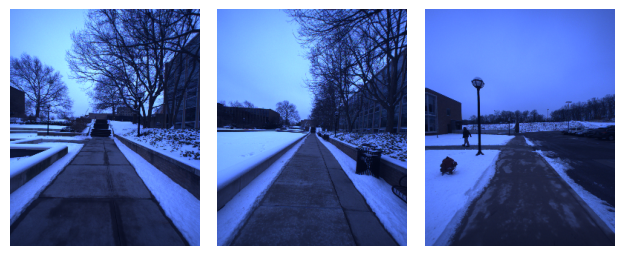

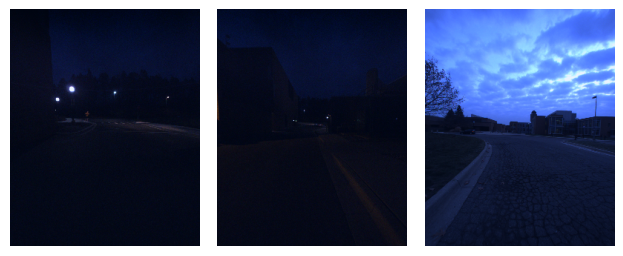

In [13]:
"""Visualize images from worst-performing queries and their database matches."""

# Check if required variables exist
if "worst_indices_global" in locals() and "worst_db_matches_global" in locals():
    # Load samples for worst queries and their database matches
    worst_queries = []
    db_matches = []

    for q_idx, db_idx in zip(worst_indices_global, worst_db_matches_global):
        try:
            worst_queries.append(dataset[q_idx])
            db_matches.append(dataset[db_idx])
        except IndexError as e:
            print(f"Warning: Could not load sample at index {q_idx} or {db_idx}: {e}")

    # Extract images for visualization (using Cam5 for NCLT, adjust for other datasets)
    image_key = "image_Cam5" if DATASET == "nclt" else "image_stereo_centre"

    if worst_queries:
        worst_queries_images = [sample[image_key] for sample in worst_queries if image_key in sample]
        if worst_queries_images:
            print("Worst query images:")
            ts.show(worst_queries_images[:3])
        else:
            print(f"No images found with key '{image_key}' in worst queries")

    if db_matches:
        worst_db_matches_images = [sample[image_key] for sample in db_matches if image_key in sample]
        if worst_db_matches_images:
            print("Corresponding database match images:")
            ts.show(worst_db_matches_images[:3])
        else:
            print(f"No images found with key '{image_key}' in database matches")

else:
    print("Required variables not available - run previous analysis cells first")